# This notebook will help understand what are the effects of the "resolution" and standard deviation of the noise on the wasserstein distance.

We will look at how increasing the resolution(number of bins) on the same area, increases the wasserstein distance. I would expect the distance to become smaller and to converge to some value.

## Some Extra functions and imports

In [64]:
import numpy as np
import ot
import pandas as pd
import matplotlib.pyplot as plt
from utils.Visualizations import *
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
import seaborn as sns
from tqdm import tqdm

In [65]:
def create_distribs(res, noise, scale_parameter = 1):
    p = make_1D_gauss(res, scale_parameter * np.floor(1 * res / 4.), scale_parameter * 2.).flatten()
    q = make_1D_gauss(res, scale_parameter * np.floor(5 * res / 8.), scale_parameter * 2.).flatten()
    X = np.linspace(0,scale_parameter,res)

    C = np.zeros([res,res],dtype=np.float64)
    dist_f1 = lambda a,b : abs(a-b)
    dist_f2 = lambda a,b : (a-b)**2
    for it1 in range(res):
        for it2 in range(res):
            C[it1,it2] = dist_f1(X[it1],X[it2])
            
    noise_p = np.random.normal(0, noise, res)
    noise_q = np.random.normal(0, noise, res)

    p_noised = p + noise_p
    q_noised = q + noise_q

    p_pos, p_neg = split_signed_measure(p_noised)
    q_pos, q_neg = split_signed_measure(q_noised)

    p_post = p_pos + q_neg
    q_post = p_neg + q_pos

    return p, q, p_post, q_post, C

In [144]:
def run_experiment_and_append(df, res, noise_param, scale_param):
    results_classic = []
    results_noised = []
    ratios_emd = []
    results_linear = []
    results_linear_noised = []
    ratios_linear = []
    
    for i in range(40):
        p, q, p_post, q_post, C = create_distribs(res, noise_param, scale_param)  
        
        results_classic_add = calc_transport_pot_emd(p, q, C)[1]
        plan_noised, log_noised = ot.unbalanced.mm_unbalanced(a=p_post, b=q_post, M=C, reg_m=10, log=True)
        results_noised_add = log_noised['cost']

        results_classic.append(results_classic_add)
        results_noised.append(results_noised_add)
        ratios_emd.append(results_classic_add/results_noised_add)
    
        results_linear.append(np.linalg.norm(p-q))
        results_linear_noised.append(np.linalg.norm(p_post-q_post))
        ratios_linear.append(np.linalg.norm(p-q)/np.linalg.norm(p_post-q_post))


    # Create new row
    new_row = {
        'Res': res,
        'Noise_Param': noise_param,
        'Scale_Param': scale_param,
        'Distances_Classic': np.mean(results_classic),
        'Distances_Noised': np.mean(results_noised),
        'Ratios_EMD': np.mean(ratios_emd),
        'Distances_Linear': np.mean(results_linear),
        'Distances_Linear_Noised': np.mean(results_linear_noised),
        'Ratios_Linear': np.mean(ratios_linear)
    }
    
    # Append new row to DataFrame
    return df._append(new_row, ignore_index=True)

## Looking at the normal case, to get a sense of things

In [229]:
resolution = 100
noise_param = 1e-3
X = np.linspace(0,1,resolution)

p = make_1D_gauss(resolution, np.floor(1 / 4.), 2.).flatten()
q = make_1D_gauss(resolution, np.floor(5 / 8.), 2.).flatten()

noise_p = np.random.normal(0, noise_param, resolution)
noise_q = np.random.normal(0, noise_param, resolution)

C = np.zeros([resolution,resolution],dtype=np.float64)
dist_f1 = lambda a,b : abs(a-b)
dist_f2 = lambda a,b : (a-b)**2
for it1 in range(resolution):
    for it2 in range(resolution):
        C[it1,it2] = dist_f1(X[it1],X[it2])

In [47]:
p_noised = p + noise_p
q_noised = q + noise_q

p_pos, p_neg = split_signed_measure(p_noised)
q_pos, q_neg = split_signed_measure(q_noised)

p_post = p_pos + q_neg
q_post = p_neg + q_pos

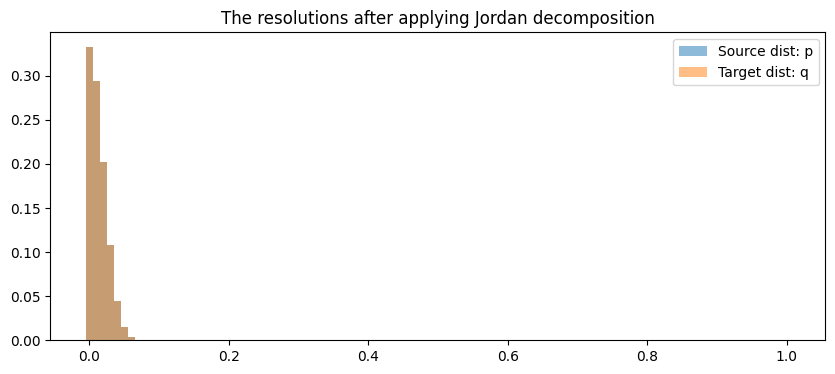

In [230]:
plot_marginals(X, p, q,'The resolutions after applying Jordan decomposition')

In [54]:
res = 100
noise_param = 5e-2
X = np.linspace(0,1,res)

p, q, p_post, q_post, C = create_distribs(res, noise_param)

results_classic = calc_transport_pot_emd(p, q, C)[1]
plan_noised, log_noised = ot.unbalanced.mm_unbalanced(a = p_post, b = q_post, M = C, reg_m=10, log=True)
results_noised = log_noised['cost']

print('Results on classic EMD:', results_classic)
print('Results on the unbalanced noised:', results_noised)
print('Ratio:', results_classic/results_noised)

print('Results on normal linear:', np.linalg.norm(p-q))
print('Results on unbalanced linear:', np.linalg.norm(p_post-q_post))
print('Ratio:', np.linalg.norm(p-q)/np.linalg.norm(p_post-q_post))

Results on classic EMD: 0.37373737373737376
Results on the unbalanced noised: 0.4475130281343933
Ratio: 0.8351430019711876
Results on normal linear: 0.5311259660135985
Results on unbalanced linear: 0.9088539814311261
Ratio: 0.5843908668114778


In [24]:
res = 1000
noise_param = 5e-2
X = np.linspace(0,1,res)

p, q, p_post, q_post, C = create_distribs(res, noise_param)

results_classic = calc_transport_pot_emd(p, q, C)[1]
plan_noised, log_noised = ot.unbalanced.mm_unbalanced(a = p_post, b = q_post, M = C, reg_m=1, log=True)
results_noised = log_noised['cost']

print('Results on classic EMD:', results_classic)
print('Results on the unbalanced noised:', results_noised)
print(results_classic/results_noised)

print('Results on normal linea r:', np.linalg.norm(p-q))
print('Results on unbalanced linear:', np.linalg.norm(p_post-q_post))
print(np.linalg.norm(p-q)/np.linalg.norm(p_post-q_post))

Results on classic EMD: 0.37537537537537546
Results on the unbalanced noised: 0.35819283292705323
1.0479700900431514
Results on normal linear: 0.5311259660135985
Results on unbalanced linear: 2.2359533146873187
0.23753893362834924


In [ ]:
plot_marginals(X, p_post, q_post, '', first_distribution_title='p_post', second_distribution_title='p')

In [ ]:
plt.plot(p_post)

## Looking at the effects of h, noise and scale.

### How does scale effect the whole thing?

In [233]:
res = 100
scale_parameter = 100
noise = 1e-2

p = make_1D_gauss(res, scale_parameter * 0.25, scale_parameter * 0.1).flatten()
q = make_1D_gauss(res, scale_parameter * 0.625, scale_parameter * 0.1).flatten()
X = np.linspace(0,scale_parameter,res)

C = np.zeros([res,res],dtype=np.float64)
dist_f1 = lambda a,b : abs(a-b)
dist_f2 = lambda a,b : (a-b)**2
for it1 in range(res):
    for it2 in range(res):
        C[it1,it2] = dist_f1(X[it1],X[it2])
            
noise_p = np.random.normal(0, noise, res)
noise_q = np.random.normal(0, noise, res)

p_noised = p + noise_p
q_noised = q + noise_q

p_pos, p_neg = split_signed_measure(p_noised)
q_pos, q_neg = split_signed_measure(q_noised)

p_post = p_pos + q_neg
q_post = p_neg + q_pos

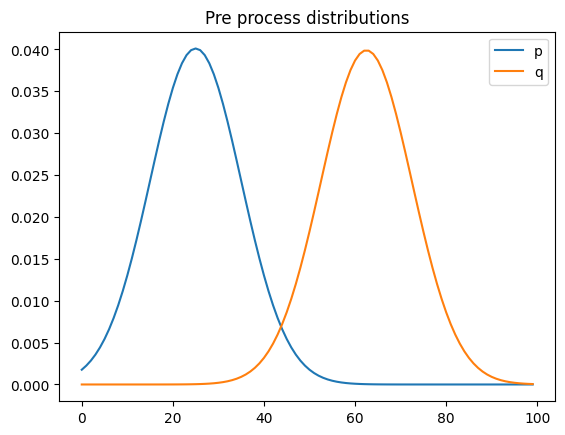

In [238]:
plt.plot(p, label='p')
plt.plot(q, label='q')

plt.title('Pre process distributions')
plt.legend()

plt.show()

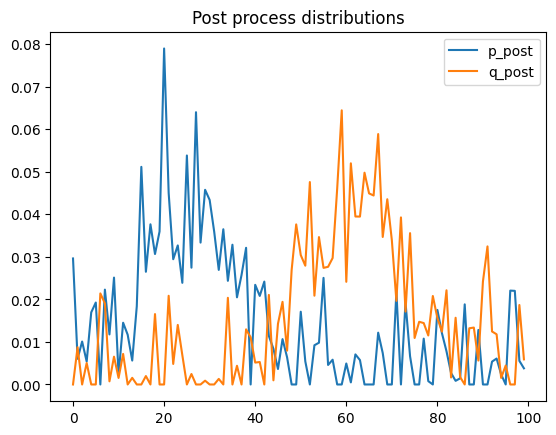

In [237]:
plt.plot(p_post, label='p_post')
plt.plot(q_post, label='q_post')

plt.title('Post process distributions')
plt.legend()

plt.show()

### Creating a full DataFrame

In [208]:
# Initialize DataFrame
columns = ['Res', 'Noise_Param', 'Scale_Param', 'Distances_Classic', 'Distances_Noised', 
           'Ratios_EMD', 'Distances_Linear', 'Distances_Linear_Noised', 'Ratios_Linear']
df = pd.DataFrame(columns=columns)

In [209]:
res_values = [10,50,100]
noise_values = [5e-2, 1e-2, 5e-3, 1e-3]
scale_values = [1,10,20,100]

In [210]:
for res in res_values:
    for noise in noise_values:
        for scale in scale_values:
            df = run_experiment_and_append(df, res=res, noise_param=noise, scale_param=scale)

C:\Users\eriki\AppData\Local\Temp\ipykernel_23496\2143969769.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return df._append(new_row, ignore_index=True)


In [211]:
len(df.index)

48

## Looking into the CDF

In [180]:
res = 100
scale_parameter = 1
noise = 1e-2

p = make_1D_gauss(res, scale_parameter * np.floor(1 * res / 4.), scale_parameter * 2.).flatten()
q = make_1D_gauss(res, scale_parameter * np.floor(5 * res / 8.), scale_parameter * 2.).flatten()
X = np.linspace(0,scale_parameter,res)

C = np.zeros([res,res],dtype=np.float64)
dist_f1 = lambda a,b : abs(a-b)
dist_f2 = lambda a,b : (a-b)**2
for it1 in range(res):
    for it2 in range(res):
        C[it1,it2] = dist_f1(X[it1],X[it2])
            
noise_p = np.random.normal(0, noise, res)
noise_q = np.random.normal(0, noise, res)

p_noised = p + noise_p
q_noised = q + noise_q

p_pos, p_neg = split_signed_measure(p_noised)
q_pos, q_neg = split_signed_measure(q_noised)

p_post = p_pos + q_neg
q_post = p_neg + q_pos

Looking into p:

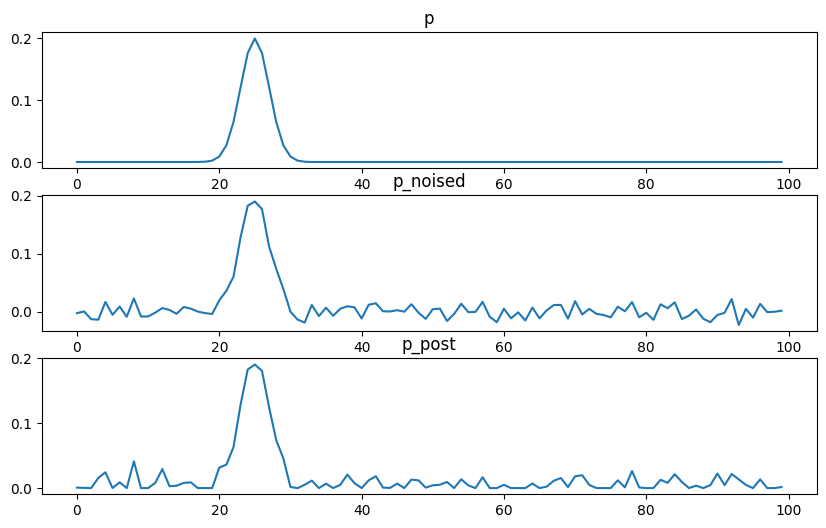

In [164]:
#looking into p

fig = plt.figure(figsize=(10, 6))

fig.add_subplot(3, 1, 1)
plt.title('p')
plt.plot(p)

fig.add_subplot(3, 1, 2)
plt.title('p_noised')
plt.plot(p_noised)

fig.add_subplot(3, 1, 3)
plt.title('p_post')
plt.plot(p_post)

Calculating the ECDF(Empirical Cumulative Distribution Function)

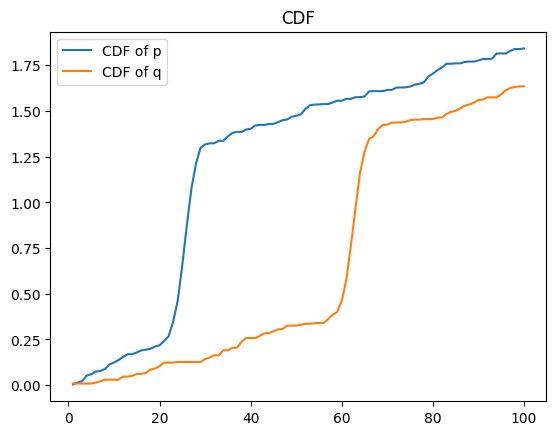

In [184]:
cumsum_p = np.cumsum(p_post)
cumsum_q = np.cumsum(q_post)
x_values = np.arange(1, res + 1)

plt.plot(x_values, cumsum_p, label='CDF of p')
plt.plot(x_values, cumsum_q, label='CDF of q')

plt.title('CDF')
plt.legend()

plt.show()

We will look at the difference between the CDF's and will get the value of the optimal transport, since the 1d version can be calculated using quantiles

In [204]:
diff = np.abs(cumsum_p - cumsum_q)
percentile_intervals = np.linspace(0,1,101)

percentile_values_p = np.zeros_like(percentile_intervals)
percentile_values_q = np.zeros_like(percentile_intervals)

# Calculate percentile values for p
for i, val in enumerate(percentile_intervals):
    idx = np.argmax(cumsum_p >= val)
    percentile_values_p[i] = p_post[idx]

# Calculate percentile values for q
for i, val in enumerate(percentile_intervals):
    idx = np.argmax(cumsum_q >= val)
    percentile_values_q[i] = q_post[idx]

diff2 = np.abs(percentile_values_p - percentile_values_q)
print(diff2.sum())

3.2327832504503164


In [193]:
print('The difference between CDFs is:', diff.sum())

The difference between CDFs is: 53.71942820657816


In [205]:
plan, log = ot.unbalanced.mm_unbalanced(a=p_post, b=q_post, M=C, reg_m=100, log=True)
cost_noised = log['cost']
print('The EMD between distributions is', cost_noised)

The EMD between distributions is 0.5063400250044428
